In [3]:
import pandas as pd
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# Epidemiology Model 


# Data 
- 1. COVID-19 US cases: Directly read data from JHU github repo.
- 2. Mobility Data provided by Apple for each county in the U.S.


In [4]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
us_confirmed_df = pd.read_csv(url, error_bad_lines=False)

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
us_death_df = pd.read_csv(url, error_bad_lines=False)

display(us_confirmed_df.head())
display(us_death_df.head())

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
global_recover_df = pd.read_csv(url, error_bad_lines=False)
display(global_recover_df.head())


url = "https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-m50.csv"
mobility = pd.read_csv(url, error_bad_lines=False)
display(mobility.head())

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,2010,2021,2023,2030,2048,2059,2074,2082,2103,2126
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,6405,6443,6475,6615,6637,6658,6694,6712,6743,6768
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,988,996,997,1012,1031,1033,1033,1042,1045,1055
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,791,801,811,825,828,840,843,850,856,861
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,1848,1873,1893,1911,1925,1932,1942,1972,1988,2009


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,29,30,30,30,31,31,31,31,31,31
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,69,69,69,69,69,69,69,69,69,69
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,9,9,9,9,9,9,9,9,9,9
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,14,14,14,14,14,14,14,15,15,15
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,24,25,25,25,25,25,25,25,25,25


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,33790,33824,33831,34010,34023,34129,34150,34217,34237,34239
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,10225,10341,10395,10466,10548,10654,10705,10808,10893,11007
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,38346,38482,38618,38788,38932,39095,39273,39444,39635,39635
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,2273,2470,2470,2729,2729,2729,2957,3029,3144,3260
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,3037,3040,3305,3384,3461,3508,3530,3647,3693,3736


,country_code,admin_level,admin1,admin2,fips,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,...,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-24,2020-10-25,2020-10-26,2020-10-27,2020-10-28
0,US,1,Alabama,NaN,1.0,8.331,10.398,10.538,10.144,10.982,...,9.570,9.834,9.980,9.908,11.684,8.053,6.684,8.868,9.398,8.766
1,US,2,Alabama,Autauga County,1001.0,7.194,14.587,13.865,13.880,14.659,...,10.325,11.047,11.757,11.570,13.286,6.866,5.692,9.670,11.121,11.131
2,US,2,Alabama,Baldwin County,1003.0,9.780,12.042,11.481,10.879,12.381,...,10.461,10.458,10.370,10.370,11.964,9.052,8.372,9.642,9.926,7.776
3,US,2,Alabama,Barbour County,1005.0,8.348,10.004,9.267,6.517,8.247,...,9.502,9.523,8.550,9.178,12.187,7.230,6.634,8.180,8.858,8.504
4,US,2,Alabama,Bibb County,1007.0,13.008,23.076,24.164,22.768,26.944,...,15.433,17.646,15.967,19.658,20.764,10.264,8.629,15.642,17.376,15.075


# Key variables of Epidemiology Model
- I, the number of infected, is in the `us_comfirmed`
- S, susceptible to COVID-19, is in `us_population` - `us_confirmed`, denoted as `us_susceptible`
- R, removed, is the sum of recovered and deceased. 
- N, population

## Parameters
- Beta: the infection rate
- D: number of days a patient can stay infected

## Goal
- With existing knowledge of I,S,R,and N, use gradient descent to figure out $\theta$ = ($\beta$, D)

In [9]:
us_confirmed_df.columns[0:12]
us_confirmed_df["Combined_Key"]

0          Autauga, Alabama, US
1          Baldwin, Alabama, US
2          Barbour, Alabama, US
3             Bibb, Alabama, US
4           Blount, Alabama, US
                 ...           
3335         Teton, Wyoming, US
3336         Uinta, Wyoming, US
3337    Unassigned, Wyoming, US
3338      Washakie, Wyoming, US
3339        Weston, Wyoming, US
Name: Combined_Key, Length: 3340, dtype: object

In [18]:
# Data Preparation
us_confirmed = us_confirmed_df.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key'],axis=1).sum(axis=0).values
us_death = us_death_df.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key',"Population"],axis=1).sum(axis=0).values
us_recovered = global_recover_df.loc[global_recover_df["Country/Region"] == "US"].drop(
    ["Province/State","Country/Region","Lat","Long"],axis= 1).values[0]
#us_removed = us_recovered+us_death
us_removed = us_recovered+us_death
us_population = us_death_df.Population.sum()
us_susceptible = us_population - us_confirmed
us_infected = us_confirmed

us_removed = us_removed[0:20]
us_susceptible = us_susceptible[0:20]
us_infected = us_infected[0:20]


In [121]:
def calculate_gradient(s,i,r,population,beta,epsilon):
    result1=0
    result2 = 0
    for n in range(len(s)-1):
        result1 += 2*(s[n+1]-s[n]+beta*s[n]*(i[n]/population))*(s[n]*i[n]/population)
        result1 += 2*(i[n+1]-i[n]-beta*s[n]*(i[n]/population) + i[n]*epsilon)*(-s[n]*i[n]/population)
        
        result2 += 2*(i[n+1]-i[n]+i[n]*epsilon-beta*i[n]*s[n]/population)*(i[n])
        result2 += 2*(r[n+1]-r[n]-i[n]*epsilon)*(-i[n])
        
    return result1,result2
def calculate(s,i,r,population):
    beta = 0.2
    epsilon = 1/10
    
    loss = 0
    length = len(s)
    for itera in range(10):
        loss1,loss2 = calculate_gradient(s,i,r,population,beta,epsilon)
        beta = beta - 0.001 * loss1/length
        epsilon = epsilon - 0.001 * loss2/length
    return beta,1/epsilon
calculate(us_susceptible,us_infected,us_removed,us_population/10000)
    

(2.5731633090691135e+73, -7.772533970409274e-70)

## Forecasting 
- After finding the most likely parameters, we can generate future forecasting from the parameters. 

In [16]:


#us_death = [0., 0., 0., 0., 1., 3., 8., 10., 13., 16., 17., 18., 23., 24., 26., 31., 39., 41., 51., 61., 73., 99., 122., 153., 209., 276., 349., 471., 599., 803., 1061., 1318., 1720., 2202., 2578., 3186., 4090.]

def sim_fun_ODE(beta, N, D, int_steps, length):
  S = np.zeros(length)
  I = np.zeros(length)
  S[0] = N
  I[0] = 53.0
  dt = 1.0/int_steps
  for l in range(length-1):
    for i in range(int_steps):
      S[l] = S[l] - beta*I[l]/N*S[l]*dt
      I[l] = I[l] + (-I[l]/D + beta*I[l]/N*S[l])*dt
    S[l+1] = S[l]
    I[l+1] = I[l]
  return S, I

def sim_fun_SDE(beta, N, D, int_steps, length):
  S = np.zeros(length)
  I = np.zeros(length)
  S[0] = N
  I[0] = 53.0
  dt = 1.0/int_steps
  for l in range(length-1):
    for i in range(int_steps):
      noise_matrix = np.matrix([[beta*I[l]*S[l]/N,-beta*I[l]*S[l]/N],[-beta*I[l]*S[l]/N, beta*I[l]*S[l]/N + I[l]/D]])
      normal_noise = np.matmul(la.sqrtm(noise_matrix), np.random.normal((1,2)))
      S[l] = S[l] - beta*I[l]/N*S[l]*dt + np.sqrt(dt)*normal_noise[0]
      I[l] = I[l] + (-I[l]/D + beta*I[l]/N*S[l])*dt + np.sqrt(dt)*normal_noise[1]
    S[l+1] = S[l]
    I[l+1] = I[l]
    return S, I

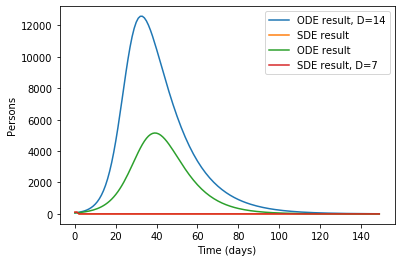

In [17]:
length = 150

beta = 0.3                  # infection rate
D = 14.0                    # average duration of the infection
N = 300000000.0/10000.0     # population size

int_steps = 20
S_ODE, I_ODE = sim_fun_ODE(beta, N, D, int_steps, length)
S_SDE, I_SDE = sim_fun_SDE(beta, N, D, int_steps, length)
plt.plot(I_ODE,label='ODE result, D=14')
plt.plot(I_SDE,label='SDE result')

plt.xlabel('Time (days)')
plt.ylabel('Persons')
plt.legend()

length = 150

beta = 0.3                  # infection rate
D = 7                   # average duration of the infection
N = 300000000.0/10000.0     # population size

int_steps = 20
S_ODE, I_ODE = sim_fun_ODE(beta, N, D, int_steps, length)
S_SDE, I_SDE = sim_fun_SDE(beta, N, D, int_steps, length)
plt.plot(I_ODE,label='ODE result')
plt.plot(I_SDE,label='SDE result, D=7')
plt.xlabel('Time (days)')
plt.ylabel('Persons')
plt.legend()
plt.show()

plt.show()

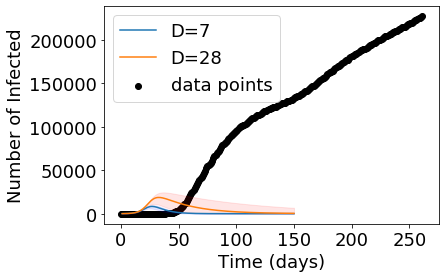

<Figure size 432x288 with 0 Axes>

In [20]:


# simulations of the ODE/SDE SIR model:
length = 150
int_steps = 20
N = 300000000.0/10000.0     # population size

# D = 5.0                    # average duration of the infection
D = 7.0*0.7                    # average duration of the infection
beta = 0.26 + 1.0/D         # infection rate
S_ODE_5, I_ODE_5 = sim_fun_ODE(beta, N, D, int_steps, length)

D = 7.0                    # average duration of the infection
beta = 0.26 + 1.0/D         # infection rate
S_ODE_7, I_ODE_7 = sim_fun_ODE(beta, N, D, int_steps, length)

# D = 10.0                    # average duration of the infection
D = 7.0*1.2                    # average duration of the infection
beta = 0.26 + 1.0/D         # infection rate
S_ODE_10, I_ODE_10 = sim_fun_ODE(beta, N, D, int_steps, length)


D = 1.0/( 1.0/(7.0*0.7) - 1.0/7.0 + 1.0/28.0 )                    # average duration of the infection
beta = 0.26 + 1.0/D         # infection rate
S_ODE_20, I_ODE_20 = sim_fun_ODE(beta, N, D, int_steps, length)

D = 28.0                    # average duration of the infection
beta = 0.26 + 1.0/D         # infection rate
S_ODE_28, I_ODE_28 = sim_fun_ODE(beta, N, D, int_steps, length)

D = 1.0/( 1.0/28.0-1.0/7.0+1.0/(7.0*1.2) )                    # average duration of the infection
beta = 0.26 + 1.0/D         # infection rate
S_ODE_30, I_ODE_30 = sim_fun_ODE(beta, N, D, int_steps, length)


fig, ax = plt.subplots()
x= np.linspace(1.0, 150.0, 150)
ax.plot(x, I_ODE_7, label='D=7')
ax.plot(x, I_ODE_28, label='D=28')
ax.scatter(range(0,len(us_death)-19,1), us_death[19:], color = 'black', marker = 'o', label='data points')
ax.fill_between(x, I_ODE_5, I_ODE_10, color='b', alpha=0.1)
ax.fill_between(x, I_ODE_20, I_ODE_30, color='r', alpha=0.1)
plt.xlabel('Time (days)', fontsize=18)
plt.ylabel('Number of Infected', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()
plt.savefig("epi_comp.eps")